# Análisis de eficacia de CallMeBaby
**Objetivo:** Realizar un análisis sobre la eficacia de los operadores de un servicio de telefonía virtual.

**Métricas empleadas:**

Para <span style="color: gold;">**definir la eficacia/ineficacia**</span> de los operadores se considera: un gran número de llamadas entrantes perdidas (internas y externas),tiempo de espera prolongado en llamadas entrantes y bajo número de llamadas salientes.

Por lo que se emplearán las siguientes métricas:
* Velocidad media de respuesta (ASA)
* Tasa de llegada de llamadas
* Volumen de llamadas salientes

**Etapas**
* EDA
* Identificar operadores ineficaces
* Prueba de hipótesis

## Diccionario de datos
`telecom_dataset_us.csv` contiene las siguientes columnas:
- `user_id`: ID de la cuenta de cliente
- `date`: fecha en la que se recuperaron las estadísticas
- `direction`: "dirección" de llamada (`out` para saliente, `in` para entrante)
- `internal`: si la llamada fue interna (entre los operadores de un cliente o clienta)
- `operator_id`: identificador del operador
- `is_missed_call`: si fue una llamada perdida
- `calls_count`: número de llamadas
- `call_duration`: duración de la llamada (sin incluir el tiempo de espera)
- `total_call_duration`: duración de la llamada (incluido el tiempo de espera)

`telecom_clients_us.csv` tiene las siguientes columnas:
- `user_id`: ID de usuario/a
- `tariff_plan`: tarifa actual de la clientela
- `date_start`: fecha de registro de la clientela

In [1]:
# importar librerías
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

In [2]:
# definir estilo de gráficos
plt.style.use('dark_background')

In [3]:
# importar datasets
calls = pd.read_csv('telecom_dataset_new.csv')
clients = pd.read_csv('telecom_clients.csv')

# EDA

In [4]:
# información sobre "calls"
calls.info()
print('\n', 'Datos duplicados:', calls.duplicated().sum())
print('\n', calls.sample(5))

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 53902 entries, 0 to 53901
Data columns (total 9 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   user_id              53902 non-null  int64  
 1   date                 53902 non-null  object 
 2   direction            53902 non-null  object 
 3   internal             53785 non-null  object 
 4   operator_id          45730 non-null  float64
 5   is_missed_call       53902 non-null  bool   
 6   calls_count          53902 non-null  int64  
 7   call_duration        53902 non-null  int64  
 8   total_call_duration  53902 non-null  int64  
dtypes: bool(1), float64(1), int64(4), object(3)
memory usage: 3.3+ MB

 Datos duplicados: 4900

        user_id                       date direction internal  operator_id  \
43505   167999  2019-10-24 00:00:00+03:00        in    False          NaN   
17207   166916  2019-11-22 00:00:00+03:00        in    False     906404.0   
21367   16703

In [5]:
# información sobre "clients"
clients.info()
print('\n', 'Datos duplicados:', clients.duplicated().sum())
print('\n', 'Total de clientes:', clients['user_id'].nunique())
print('\n', clients.sample(5))

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 732 entries, 0 to 731
Data columns (total 3 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   user_id      732 non-null    int64 
 1   tariff_plan  732 non-null    object
 2   date_start   732 non-null    object
dtypes: int64(1), object(2)
memory usage: 17.3+ KB

 Datos duplicados: 0

 Total de clientes: 732

      user_id tariff_plan  date_start
30    168112           A  2019-10-14
141   167958           C  2019-10-07
270   167618           C  2019-09-23
480   167250           B  2019-09-09
636   166795           B  2019-08-19


### Comentario
En el DataFrame de "calls" se encontró valores ausentes y 4,900 duplicados, además, hay que realizar una transformación de tipo de datos. Por otro lado en el DataFrame de "clients" también hay que realizar una transformación de tipo de datos.

In [6]:
clients.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 732 entries, 0 to 731
Data columns (total 3 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   user_id      732 non-null    int64 
 1   tariff_plan  732 non-null    object
 2   date_start   732 non-null    object
dtypes: int64(1), object(2)
memory usage: 17.3+ KB


## Procesamiento de datos

In [7]:
# procesamiento en "calls" y "clients"
# calls
# transformación de tipo de datos
calls['user_id'] = calls['user_id'].astype('str')
calls['date'] = pd.to_datetime(calls['date'])
calls['is_missed_call'] = calls['is_missed_call'].astype('str')
# manejo de valores ausentes 
calls['operator_id'] = calls['operator_id'].fillna(999).astype('int')              # rellenar nulos con "999" y convertir a int
calls['operator_id'] = calls['operator_id'].astype('str').replace('999', 'unknow') # convertir a str y remplazar por "unknow"
calls = calls.dropna()                                                             # se borraron los ausentes (117) en columna "internal" 
# manejo de duplicados
calls = calls.drop_duplicates()

# clients
# transformación de tipo de datos
clients['user_id'] = clients['user_id'].astype('str')
clients['date_start'] = pd.to_datetime(clients['date_start'])

In [8]:
# ordenar por fecha
calls = calls.sort_values(by='date')

### Comentario
Los valores nulos en ``"operator_id"`` fueron reemplazados con la etiqueta "unknow".

## Análisis de métricas de desempeño

In [9]:
# agregar tiempo de espera de la llamada
calls['waiting_time'] = calls['total_call_duration'] - calls['call_duration']
# agregar día
calls['dt'] = calls['date'].dt.date
# agregar plan de tarifa a cada cliente
calls = calls.merge(clients[['user_id', 'tariff_plan']], on='user_id', how='left')

In [10]:
print('Start of period:', calls['date'].min())
print('End of period:', calls['date'].max())

Start of period: 2019-08-02 00:00:00+03:00
End of period: 2019-11-28 00:00:00+03:00


Total calls in period: 806484


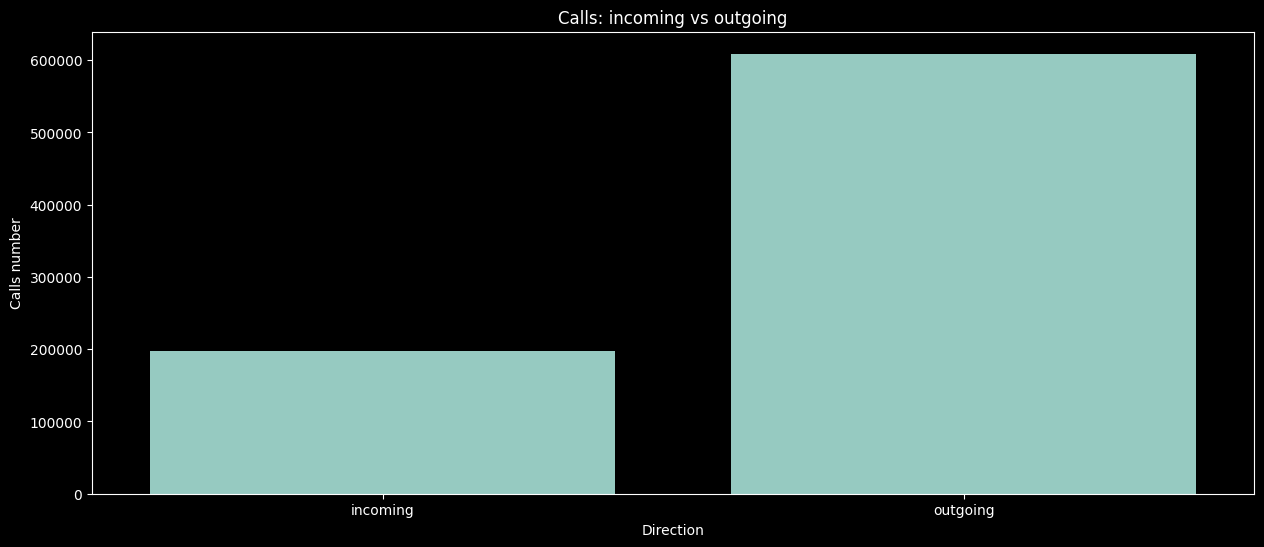

In [11]:
# número de llamadas entrantes vs salientes
# agrupar por dirección de la llamada
direction_calls = calls.groupby('direction', as_index=False)['calls_count'].sum()
direction_calls['direction'] = direction_calls['direction'].replace({'in':'incoming', 'out':'outgoing'})

print('Total calls in period:',direction_calls['calls_count'].sum())

# gráfico de barras: llamadas entrantes vs salientes
plt.figure(figsize=[15,6])
sns.barplot(direction_calls,
            x='direction',
            y='calls_count')
plt.title('Calls: incoming vs outgoing')
plt.ylabel('Calls number')
plt.xlabel('Direction')
plt.show()

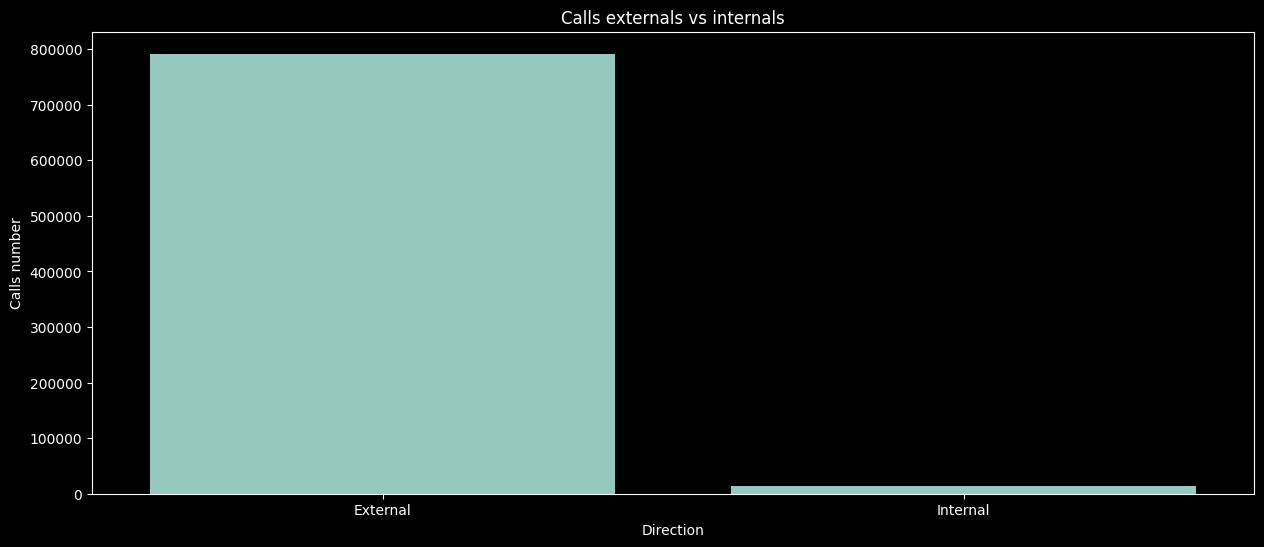

In [12]:
# número de llamadas externas vs internas
# agrupar por dirección de la llamada
internal_calls = calls.groupby('internal', as_index=False)['calls_count'].sum()
internal_calls['internal'] = internal_calls['internal'].replace({False: 'External', True:'Internal'})

# gráfico de barras: llamadas externas vs internas
plt.figure(figsize=[15,6])
sns.barplot(internal_calls,
            x='internal',
            y='calls_count')
plt.title('Calls externals vs internals')
plt.ylabel('Calls number')
plt.xlabel('Direction')
plt.show()


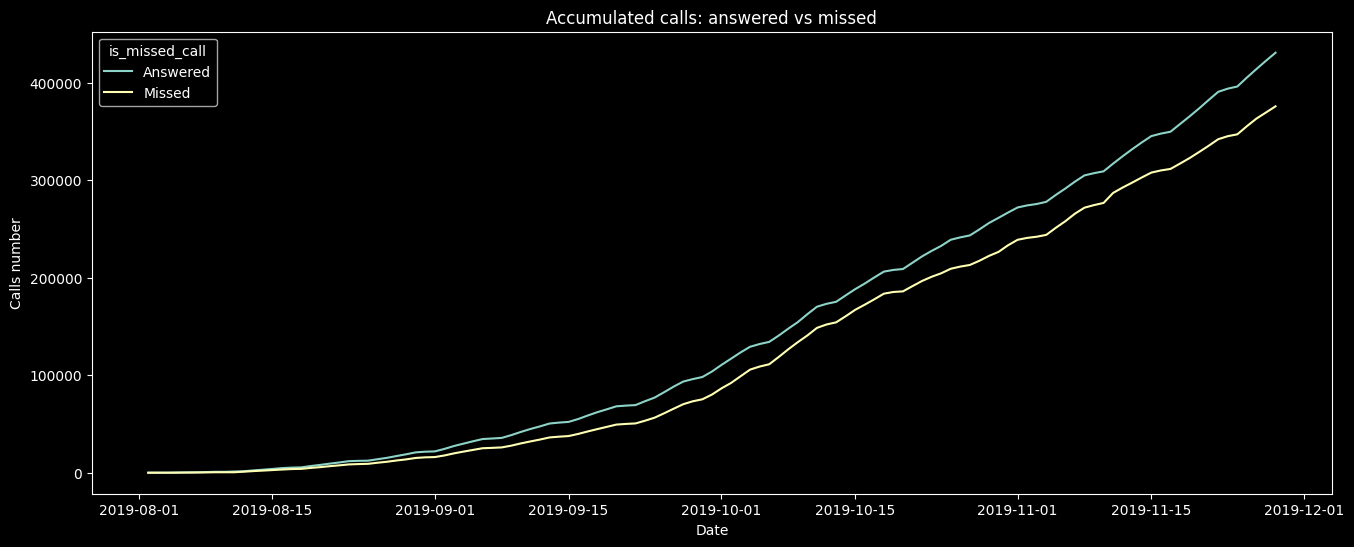

In [13]:
missed_calls = (
    calls.groupby(['dt', 'is_missed_call'], as_index=False)
    .agg({'calls_count':'sum'})
)

missed_calls['is_missed_call'] = missed_calls['is_missed_call'].replace({'False':'Answered', 'True':'Missed'})
missed_calls['calls_cumulative'] = missed_calls.groupby('is_missed_call')['calls_count'].transform('cumsum')

plt.figure(figsize=[16,6])
sns.lineplot(missed_calls,
             x='dt',
             y='calls_cumulative',
             hue='is_missed_call')
plt.title('Accumulated calls: answered vs missed')
plt.ylabel('Calls number')
plt.xlabel('Date')
plt.show()
plt.show()

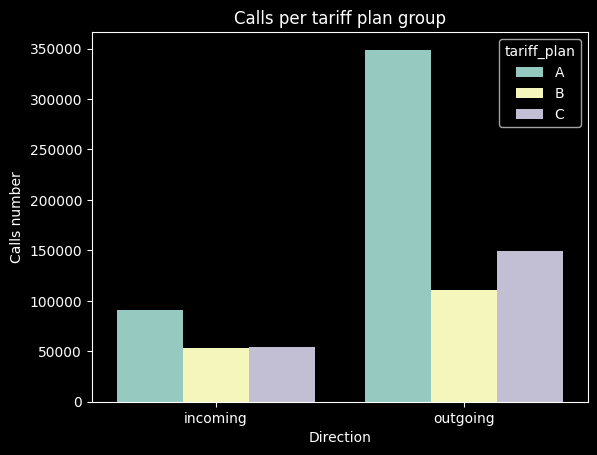

In [14]:
# número de llamadas por usuarios de cada plan
# agrupar por tipo de llamada
calls_per_tariffplan = calls.groupby(['tariff_plan', 'direction'], as_index=False)['calls_count'].sum()
calls_per_tariffplan['direction'] = calls_per_tariffplan['direction'].replace({'in':'incoming', 'out':'outgoing'})

# gráfico de barras: llamadas por usuarios de cada plan
sns.barplot(calls_per_tariffplan,
            x='direction',
            y='calls_count',
            hue='tariff_plan')
plt.title('Calls per tariff plan group')
plt.ylabel('Calls number')
plt.xlabel('Direction')
plt.show()

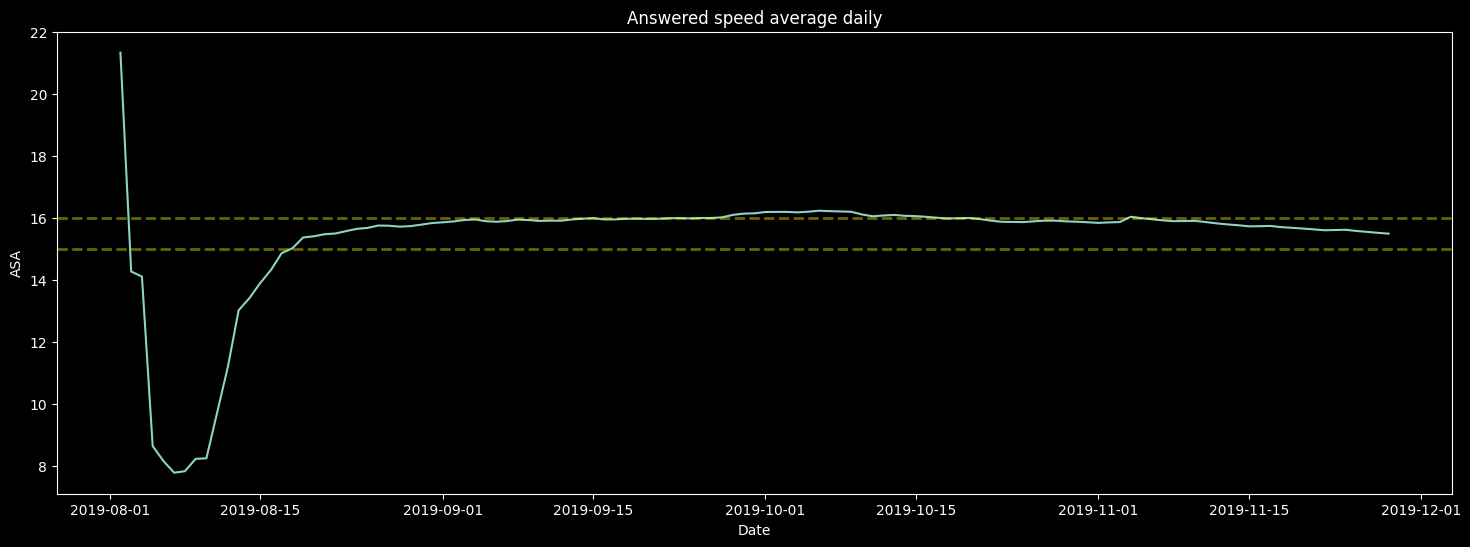

In [15]:
# velocidad media de respuesta (ASA)
# filtrar por llamadas atendidas
answered_calls = calls.query('is_missed_call != "True"')

# calcular ASA (total waiting time / calls number)
ASA = (
    answered_calls.groupby('dt', as_index=False)
    .agg({'calls_count':'sum', 'waiting_time':'sum'})
)

ASA['total_calls'] = ASA['calls_count'].cumsum()
ASA['total_waiting_time'] = ASA['waiting_time'].cumsum()
ASA['asa'] = ASA['total_waiting_time'] / ASA['total_calls']

# gráfico de líneas: ASA por día
plt.figure(figsize=[18,6])

sns.lineplot(ASA,
            x='dt',
            y='asa')
plt.title('Answered speed average daily')
plt.ylabel('ASA')
plt.xlabel('Date')
plt.axhline(y=16, color='yellow', linestyle='--', linewidth=2, alpha=0.4)
plt.axhline(y=15, color='yellow', linestyle='--', linewidth=2, alpha=0.4)
plt.show()

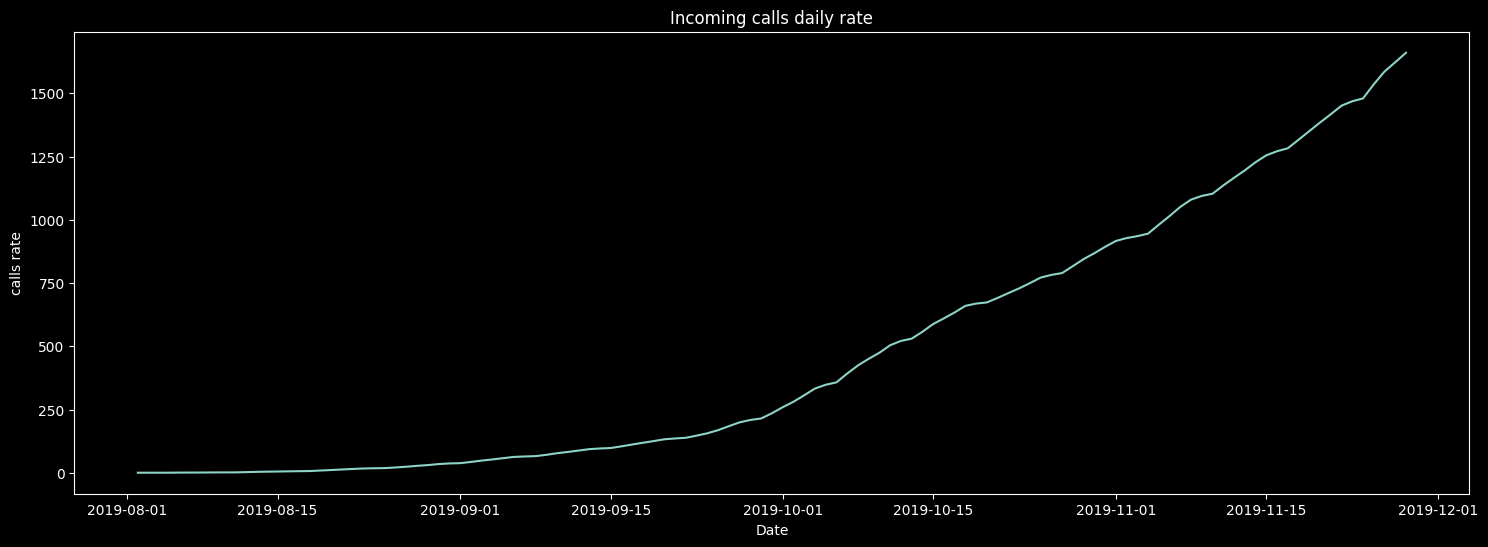

In [16]:
# tasa de llegada de llamadas
# filtrar por llamadas entrantes
incoming_calls = calls.query('direction == "in"')

# calcular tasa de llegada de llamadas (daily calls / total calls)
incoming_calls_rate = (
    incoming_calls.groupby('dt', as_index=False)
    .agg({'calls_count':'sum'})
)

incoming_calls_rate['total_calls'] = incoming_calls_rate['calls_count'].cumsum()
incoming_calls_rate['calls_rate'] = incoming_calls_rate['total_calls'] / len(incoming_calls_rate)

# gráfico de líneas: tasa diaria de llegada de llamadas
plt.figure(figsize=[18,6])

sns.lineplot(incoming_calls_rate,
             x='dt',
             y='calls_rate')
plt.title('Incoming calls daily rate')
plt.ylabel('calls rate')
plt.xlabel('Date')
plt.show()

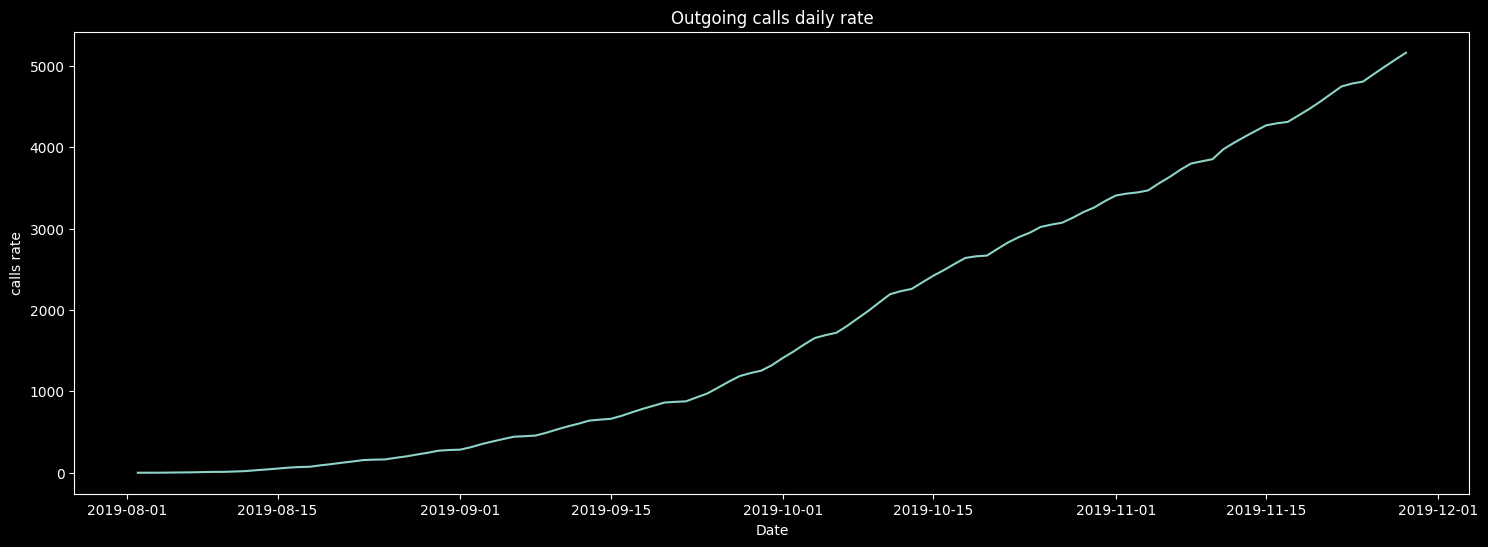

In [17]:
# volumen de llamadas salientes
# filtrar por llamadas salientes
incoming_calls = calls.query('direction == "out"')

# calcular tasa de llegada de llamadas (daily calls / total calls)
outgoing_calls_rate = (
    incoming_calls.groupby('dt', as_index=False)
    .agg({'calls_count':'sum'})
)

outgoing_calls_rate['total_calls'] = outgoing_calls_rate['calls_count'].cumsum()
outgoing_calls_rate['calls_rate'] = outgoing_calls_rate['total_calls'] / len(outgoing_calls_rate)

# gráfico de líneas: tasa diaria de llegada de llamadas
plt.figure(figsize=[18,6])

sns.lineplot(outgoing_calls_rate,
             x='dt',
             y='calls_rate')
plt.title('Outgoing calls daily rate')
plt.ylabel('calls rate')
plt.xlabel('Date')
plt.show()

In [18]:
# operadores desconicdos
operators_unknow = calls.query('operator_id == "unknow"')
print('Llamadas de operadores desconocidos:',operators_unknow['calls_count'].sum())

Llamadas de operadores desconocidos: 104399


### Comentario
De manera general, durante el periodo del 2-Oct al 28-Nov del 2029, se registró un total de 806,484 llamadas de las cuales la mayoría fueron salientes y menos del 2% fueron llamadas internas. Del total de llamadas casi la mitad fueron perdidas (no se contestaron). Con respecto a los planes de tarifa de los clientes, se hicieron y recibieron más llamadas para los clientes "A".

En cuanto a las métricas de rendimiento: la velocidad de respuesta de llamada terminó entrono a los 15 segundos, la tasa de llamadas diarias entrantes es de 1,600 y la tasa de llamadas salientes es de 5,159.

Para el análisis de los operadores ineficaces <span style="color: gold;">**no se tomaran en cuenta los registros de operadores desconocidos**</span>.